## EPL Shot Simulation
For today's viz we'll simulate the probabilities that a player scored an  amount of goals based on their xG figures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text

from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [3]:
spaceMono_bold = 'https://github.com/googlefonts/spacemono/blob/main/fonts/SpaceMono-BoldItalic.ttf?raw=true'

from mplsoccer import FontManager
monoBFont = FontManager(spaceMono_bold)

In [7]:
df = pd.read_csv('/work/assets/10312022_epl_shots.csv', index_col=0)
df

,shot_id,event_type,team_id,player_id,player_name,shot_x,shot_y,min,min_added,is_blocked,...,goal_crossed_z,xG,xGOT,shot_type,situation,period,is_own_goal,on_goal_x,on_goal_y,short_name
0,2443406693,AttemptSaved,8654,523825,Jarrod Bowen,95.929825,33.008751,2,NaN,True,...,1.220000,0.173840,NaN,LeftFoot,FromCorner,FirstHalf,False,55.892857,14.239029,NaN
1,2443411697,AttemptSaved,8654,158545,Michail Antonio,96.991227,38.704525,2,NaN,True,...,1.245684,0.082090,NaN,LeftFoot,RegularPlay,FirstHalf,False,7.782738,14.538798,NaN
2,2443406789,Miss,8654,158545,Michail Antonio,97.087716,34.686251,3,NaN,False,...,3.376828,0.090813,NaN,Header,FromCorner,FirstHalf,False,102.929726,39.412087,NaN
3,2443411153,AttemptSaved,8456,169200,Kevin De Bruyne,81.471358,22.668026,9,NaN,True,...,1.220000,0.019727,NaN,LeftFoot,RegularPlay,FirstHalf,False,62.247024,14.239029,NaN
4,2443414481,Miss,8456,169200,Kevin De Bruyne,90.699997,25.129062,14,NaN,False,...,0.269684,0.138967,NaN,RightFoot,RegularPlay,FirstHalf,False,0.000000,3.147575,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3212,2479039649,AttemptSaved,9879,182962,Tom Cairney,90.699997,38.032142,78,NaN,True,...,1.220000,0.072628,NaN,LeftFoot,RegularPlay,SecondHalf,False,66.785714,14.239029,NaN
3213,2479040285,AttemptSaved,9879,502420,Harrison Reed,83.723785,21.406879,79,NaN,True,...,1.220000,0.026571,NaN,RightFoot,FromCorner,SecondHalf,False,45.000000,14.239029,NaN
3214,2479040459,AttemptSaved,9879,94086,Willian,90.900002,41.367812,79,NaN,False,...,0.122000,0.088496,0.1026,RightFoot,RegularPlay,SecondHalf,False,59.523810,1.423903,NaN
3215,2479043471,Miss,9879,351860,Aleksandar Mitrovic,93.400002,28.875237,86,NaN,False,...,0.269684,0.017457,NaN,Header,FromCorner,SecondHalf,False,164.041950,3.147575,NaN


In [8]:
top_scorers = (
    df[(df['is_own_goal'] == False) & (df['event_type'] == 'Goal')]
    .groupby(['player_id', 'player_name', 'event_type', 'team_id'])
    .agg({'shot_id':'count'})
    .reset_index()
    .rename(columns={'shot_id':'goals'})
)
top_scorers = top_scorers.sort_values(by='goals', ascending=False).head(6).reset_index(drop=True)
top_scorers

,player_id,player_name,event_type,team_id,goals
0,737066,Erling Braut Haaland,Goal,8456,17
1,194165,Harry Kane,Goal,8586,10
2,351860,Aleksandar Mitrovic,Goal,9879,9
3,408987,Ivan Toney,Goal,9937,8
4,318615,Leandro Trossard,Goal,10204,7
5,442277,Miguel Almiron,Goal,10261,7


In [9]:
df = df[df['player_id'].isin(top_scorers['player_id'])]

In [11]:
### Simulating the number of goals
def sim_goal_on_xG(xG):
    goal = np.random.choice([0,1], p=[1-xG, xG])
    return goal

def sim_player_goals(player_id, simulations=1000, data=df):
    df = data.copy()
    player_df = df[df['player_id'] == player_id]
    simulation_track = {
        'goals': [],
        'simulation_id': []
    }
    for sim in range(0, simulations):
        total_goals = 0
        for x in player_df['xG']:
            goal = sim_goal_on_xG(x)
            total_goals += goal
        simulation_track['goals'].append(total_goals)
        simulation_track['simulation_id'].append(sim)
    simulation_track = pd.DataFrame(simulation_track)
    return simulation_track

In [12]:
toney = sim_player_goals(408987, simulations=5000)

In [13]:
toney = toney.groupby(['goals']).count().reset_index()
toney['prob'] = toney['simulation_id']/5000

In [14]:
df_simulated = pd.DataFrame()
for player in top_scorers['player_id']:
    df_aux = sim_player_goals(player, simulations=5000)
    df_aux = df_aux.groupby(['goals']).count().reset_index()
    df_aux['prob'] = df_aux['simulation_id']/5000
    df_aux['player_id'] = player
    df_simulated = pd.concat([df_simulated, df_aux])
df_simulated = df_simulated.reset_index(drop=True)

In [21]:
def plot_goal_sim(ax, player_id, label_x=False, label_y=False):
    ax.set_xlim(df_simulated['goals'].min(), df_simulated['goals'].max())
    ax.set_ylim(0, .3)

    true_goals = top_scorers[top_scorers['player_id'] == player_id].goals.iloc[0]
    player_sim = df_simulated[df_simulated['player_id'] == player_id]

    bars_ = ax.bar(player_sim['goals'], player_sim['prob'], fc='#FE9A0A', hatch='ooooo')
    # -- We need to compute the location of the bar of the actual goals
    min_goals = player_sim['goals'].min()
    true_goal_pos = true_goals - min_goals
    bars_[true_goal_pos].set_color('#13B042')
    bars_[true_goal_pos].set_hatch('ooooo')
    bars_[true_goal_pos].set_edgecolor('#0FFC56')
    true_goal_prob = bars_[true_goal_pos].get_height()

    ax.annotate(
        xy=(true_goals, true_goal_prob),
        text=f'{true_goal_prob:.1%}',
        xytext=(2,10),
        textcoords='offset points',
        ha='center',
        va='center',
        color='#0FFC56',
        size=7
    )

    ax.yaxis.set_major_locator(ticker.MultipleLocator(.05))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
    if label_x:
        ax.set_xlabel('Goals', color='white')
    if label_y:
        ax.set_ylabel('Probability', color='white')

    # -- Let's get fancy
    ax.annotate(
        text='', xy=(0.5, .28), 
        xytext=(true_goals - .5, .28), 
        arrowprops=dict(arrowstyle='<->', color='#FFFFFF'), color='white')
    under_prob = player_sim[player_sim['goals'] < true_goals]['prob'].sum()
    ax_text(
        s=f'{under_prob:.1%} of underperf.\n', x=(0.5 + true_goals - .5)/2, y=.285, 
        ha='center', va='bottom', color='white', size=5, 
#         highlight_textprops=[{'color':'#0FFC56'}], 
        ax=ax)
    if (ax.get_xlim()[1] - 0.5 - true_goals + 1) > 3:
        ax.annotate(
            text='', xy=(ax.get_xlim()[1] - 0.5, .28), 
            xytext=(true_goals + 1, .28), 
            arrowprops=dict(arrowstyle='<->', color='#FFFFFF'), color='white')
        over_prob = player_sim[player_sim['goals'] > true_goals]['prob'].sum()
        ax_text(
            s=f'{over_prob:.1%} of outperf.\n', x=true_goals + 1 + (ax.get_xlim()[1] - true_goals - 1)/2, y=.285, 
            ha='center', va='bottom', color='white', size=5, 
#             highlight_textprops=[{'color':'#0FFC56'}], 
            ax=ax)

    # -- Player title
    player_name = top_scorers[top_scorers['player_id'] == player_id]['player_name'].iloc[0]
    xG_player = df[df['player_id'] == player_id]['xG'].sum()
    xGOT_player = df[df['player_id'] == player_id]['xGOT'].sum()
    ax_text(
        x=0, y=ax.get_ylim()[1]*1.1,
        s=f"<{player_name}> | Goals {true_goals:.0f} | xG {xG_player:.1f} | xGOT {xGOT_player:.1f}",
        size=6,
        color='white',
        ha='left',
        va='center',
#         highlight_textprops=[{'size':12}],
        ax=ax
    )

findfont: Font family ['Comico'] not found. Falling back to DejaVu Sans.


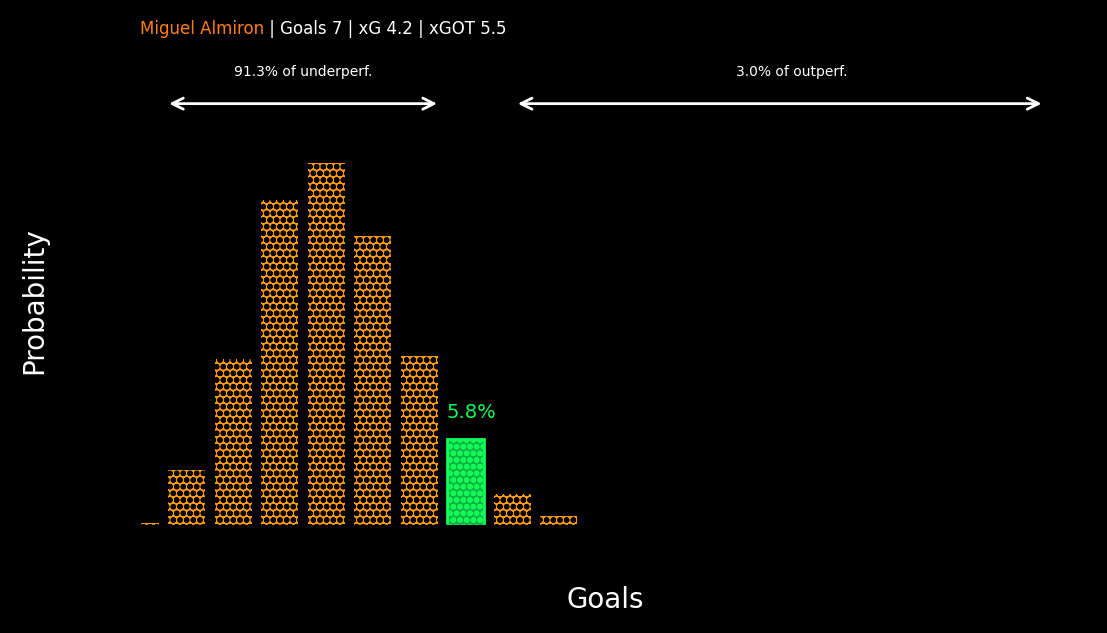

In [22]:
fig = plt.figure(figsize=(6,3), dpi=200, facecolor='#000000')
ax = plt.subplot(facecolor='#000000')

plot_goal_sim(ax, player_id=442277, label_x=True, label_y=True)

[[Text(0.1, 0.9889285714285714, "Simulation of goals scored based on the xG of each player's actual shots taken. | Viz by @sonofacorner")]]

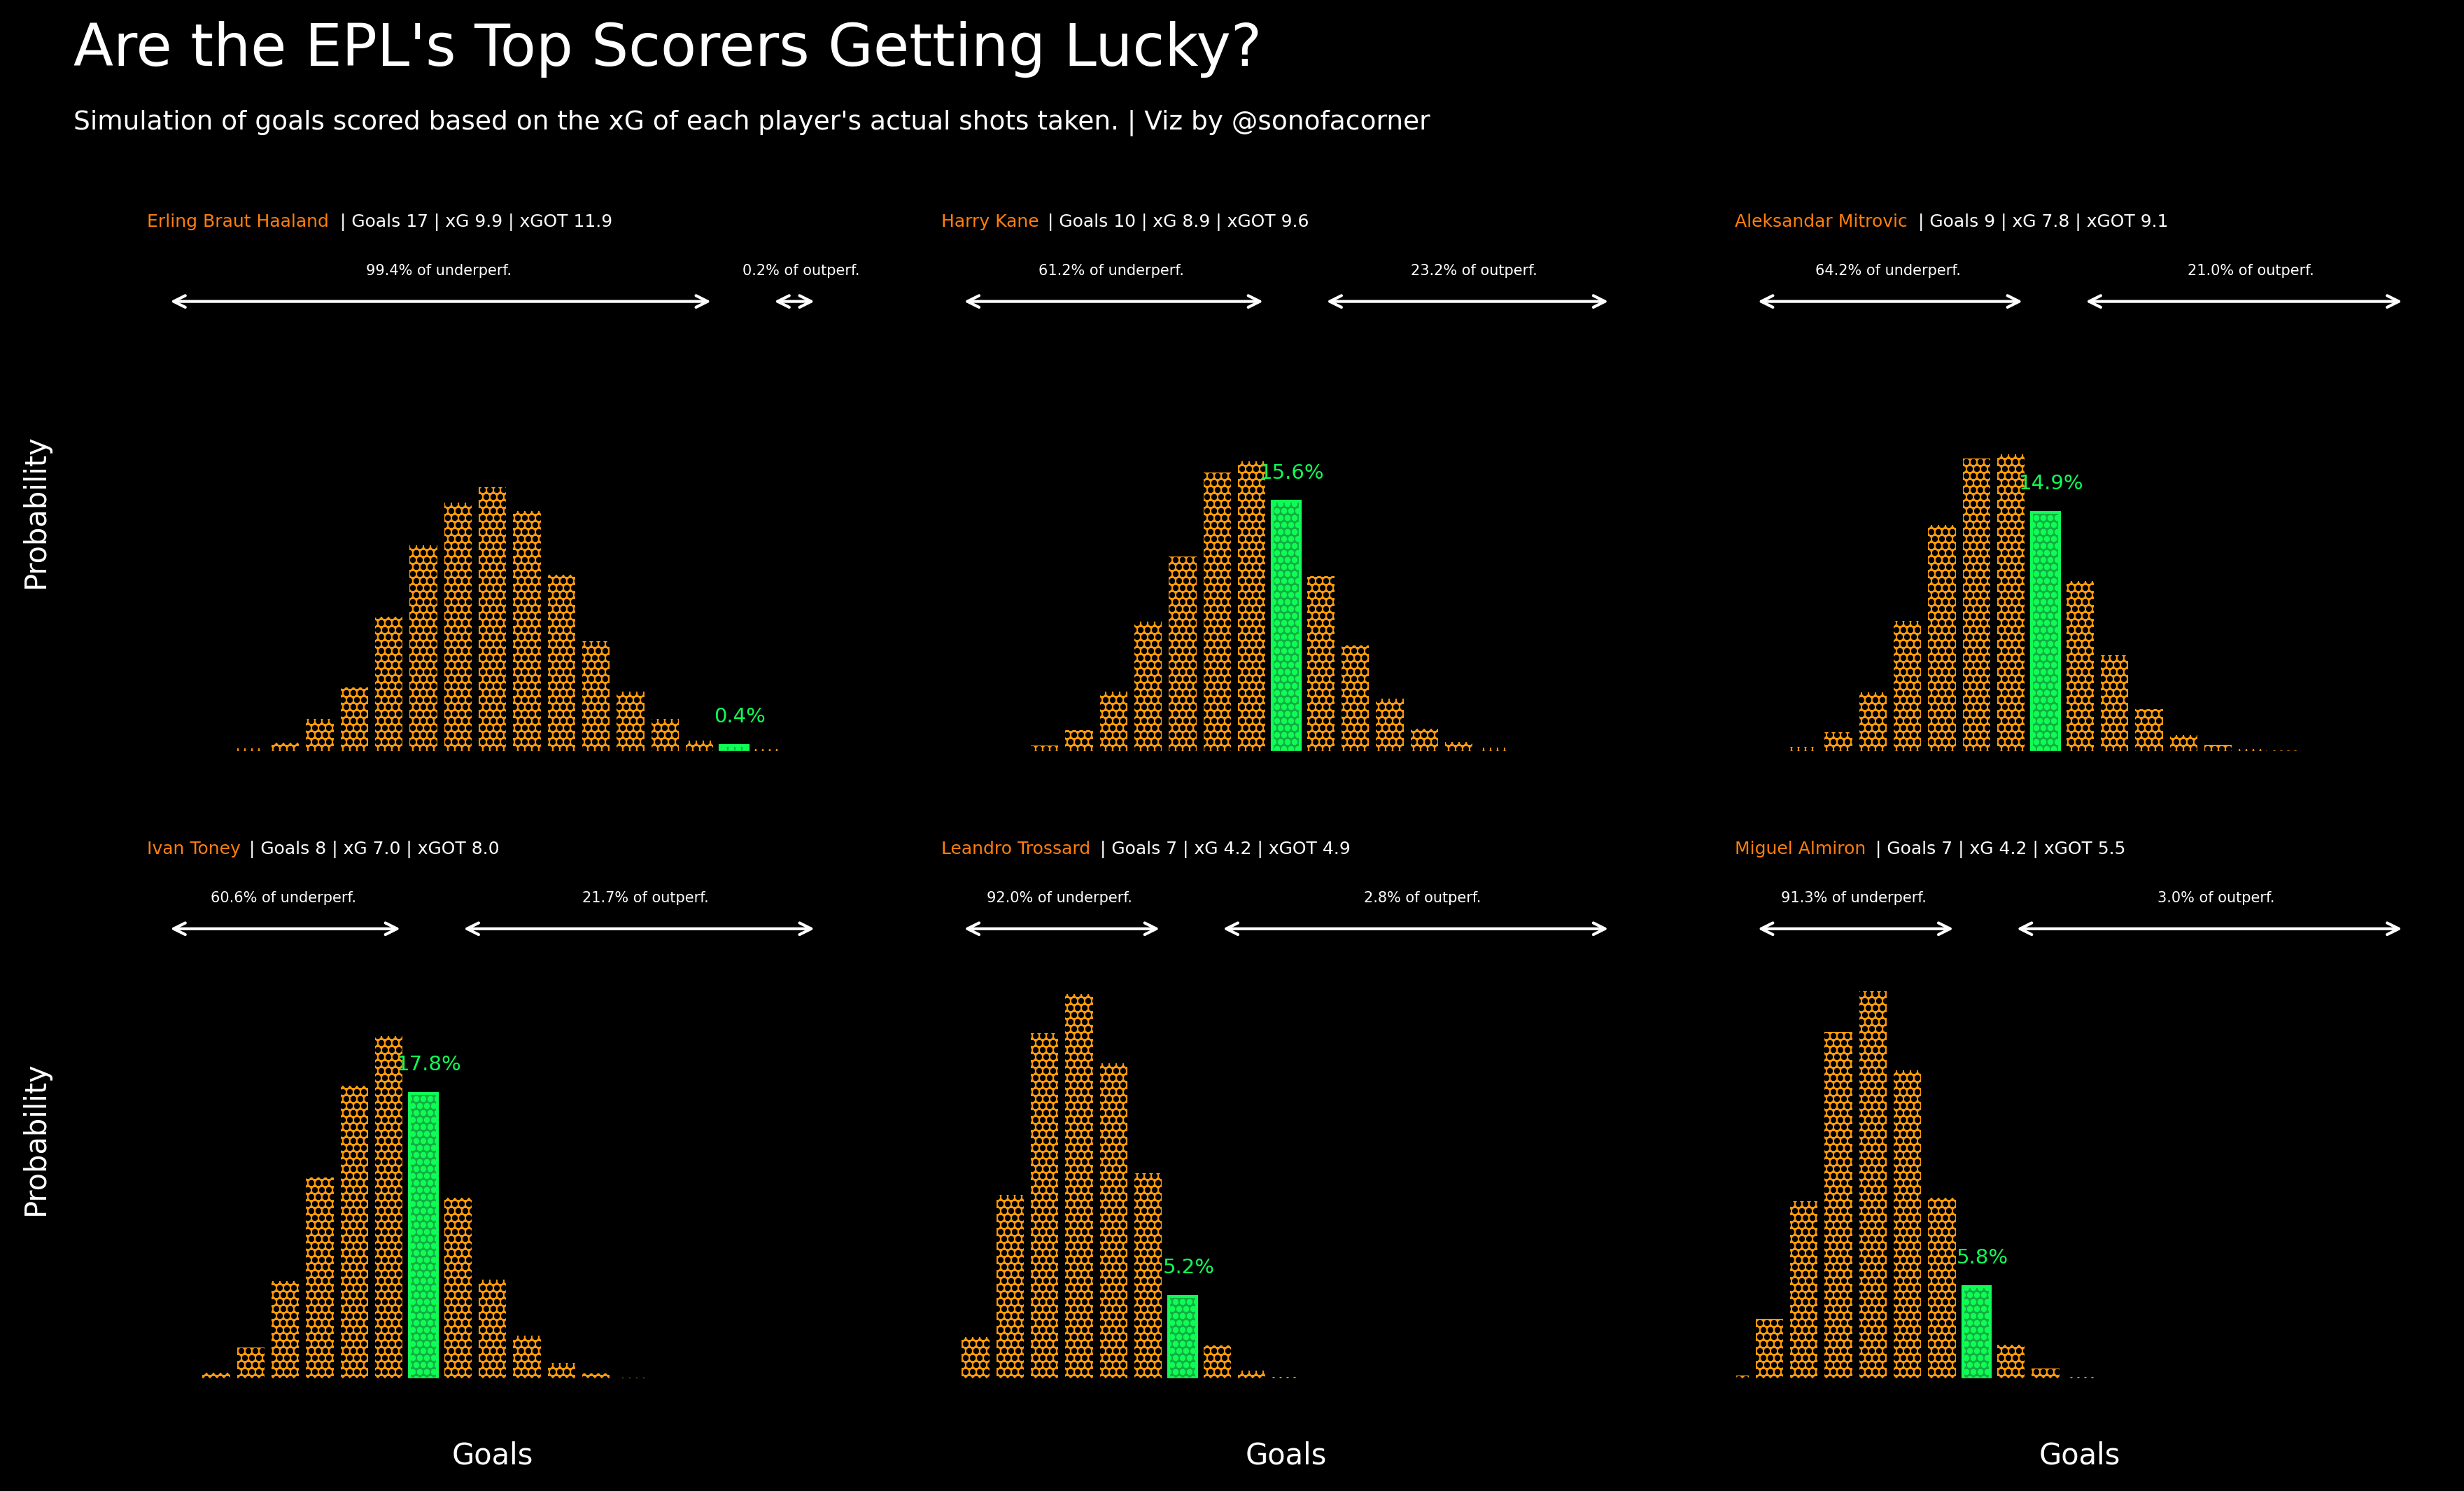

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7), dpi=300, facecolor='#000000')
axs = np.array(axs)
for index, ax in enumerate(axs.reshape(-1)):
    ax.set_facecolor('#000000')
    if index < 3:
        label_x = False
    else:
        label_x = True
    if index in [0,3]:
        label_y = True
    else:
        label_y = False
    plot_goal_sim(ax, player_id=top_scorers['player_id'].iloc[index], label_x=label_x, label_y=label_y)

plt.subplots_adjust(wspace=0.15, hspace=.3)
# We add the logos once we've reshaped the figure
fig_text(
    x=0.1,y=1.03,
    s='Are the EPL\'s Top Scorers Getting Lucky?',
    ha='left',
    va='center',
    size='20',
    color='white'  
)
fig_text(
    x=0.1,y=.98,
    s='Simulation of goals scored based on the xG of each player\'s actual shots taken. | Viz by @sonofacorner',
    ha='left',
    va='center',
    size='9',
    color='white'  
)